In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import pickle
import sys
import tifffile as tf
sys.path.append("..")
from utils_io import get_imaging_files
from utils_image import getMeanTiff_equalsampling, UnrotateCropFrame, RegFrame, hist_match, compute_zpos_sp
from utils_analysis import plot_trajectory, getLinearSpeed, getAngularSpeed
from scanimagetiffio import SITiffIO  
#gaussian_filter1d
from scipy.ndimage import gaussian_filter1d

In [2]:
def convertto255(img):
    img = img.astype(np.float32)
    #normalize to 0-1 according to min max
    img = (img - np.min(img))/(np.max(img) - np.min(img))
    img = img*255
    img = img.astype(np.uint8)
    return img

### 1, get the z correlation of data under 183_03082023

In [3]:
datafolder = "/media/zilong/4TB Storage HDD/2PImaging/183_03082023/"
processed_datafolder = os.path.join(datafolder, 'UnrotTiff/suite2p/plane0')
RegTif_folder = os.path.join(processed_datafolder, 'reg_tif')
savefolder = os.path.join(datafolder, 'UnrotTiff/2D2P')
#load ops
ops =  np.load(os.path.join(processed_datafolder, 'ops.npy'), allow_pickle=True)
ops = ops.item()

#load meanstacks.npy from datafolder, DP_exp
meanstacks = np.load(os.path.join(datafolder, "DP_exp", "meanstacks.npy"))

#cut the middle 40 rows of the meanstacks
meanstacks_cut = meanstacks[int(meanstacks.shape[0]/2)-20:int(meanstacks.shape[0]/2)+21, :, :]
#save the meanstacks_cut to tiff file
tf.imsave(os.path.join(savefolder, 'meanstacks_cut.tif'), meanstacks_cut)

binsize = 10
savefolder = os.path.join(datafolder, 'UnrotTiff/2D2P')
corrMatName = 'corrMatrix_binsize_' + str(binsize) + '_40mins_41stacks.pkl'
#check if corrMatrix.pkl exists under savefolder
if os.path.isfile(os.path.join(savefolder, corrMatName)):
    with open(os.path.join(savefolder, corrMatName), 'rb') as f:
        all_corrMatrix = pickle.load(f)
else:
    #read all tif under the folder RegTif_folder 
    filenames = os.listdir(RegTif_folder)
    #sort the filenames by number
    filenames.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))
    #keep the first 50000 frames, which are the first 100 files
    filenames = filenames[:144]
    # Load the registered tiff image
    all_corrMatrix = {}
    for filename in filenames:
        print('processing: ' + filename)
        regFrames = []
        with tf.TiffFile(os.path.join(RegTif_folder, filename)) as tif:
            for page in tif.pages:
                image = page.asarray()
                #transpose the image because the image is rotated after suite2p processing
                regFrames.append(image.T)
        regFrames = np.array(regFrames)
        
        #bin every binsize frames and take the mean
        bin_regFrames = regFrames.reshape(-1, binsize, regFrames.shape[1], regFrames.shape[2]).mean(axis=1)
                
        #perform phase correlation
        _, _, corrMatrix = compute_zpos_sp(meanstacks_cut, bin_regFrames, ops)
        
        #append the corrMatrix to all_corrMatrix
        all_corrMatrix[filename] = corrMatrix 
    
    #save the all_corrMatrix to pickle file
    with open(os.path.join(savefolder, corrMatName), 'wb') as f:
        pickle.dump(all_corrMatrix, f)

#for all elements in all_corrMatrix, concatenate them by the first dimension
corrMatrix_correct = np.concatenate(list(all_corrMatrix.values()), axis=1)

/tmp/ipykernel_374447/2810798338.py:15: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  tf.imsave(os.path.join(savefolder, 'meanstacks_cut.tif'), meanstacks_cut)


### 2, comparing zdrift uncorrected and corrected from two imaging sessions (note that these two sessions are recorded from two different mice)

/tmp/ipykernel_374447/3281183482.py:105: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  tf.imsave(os.path.join(savefolder, 'meanstacks_cut.tif'), meanstacks_cut)
/tmp/ipykernel_374447/3281183482.py:176: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


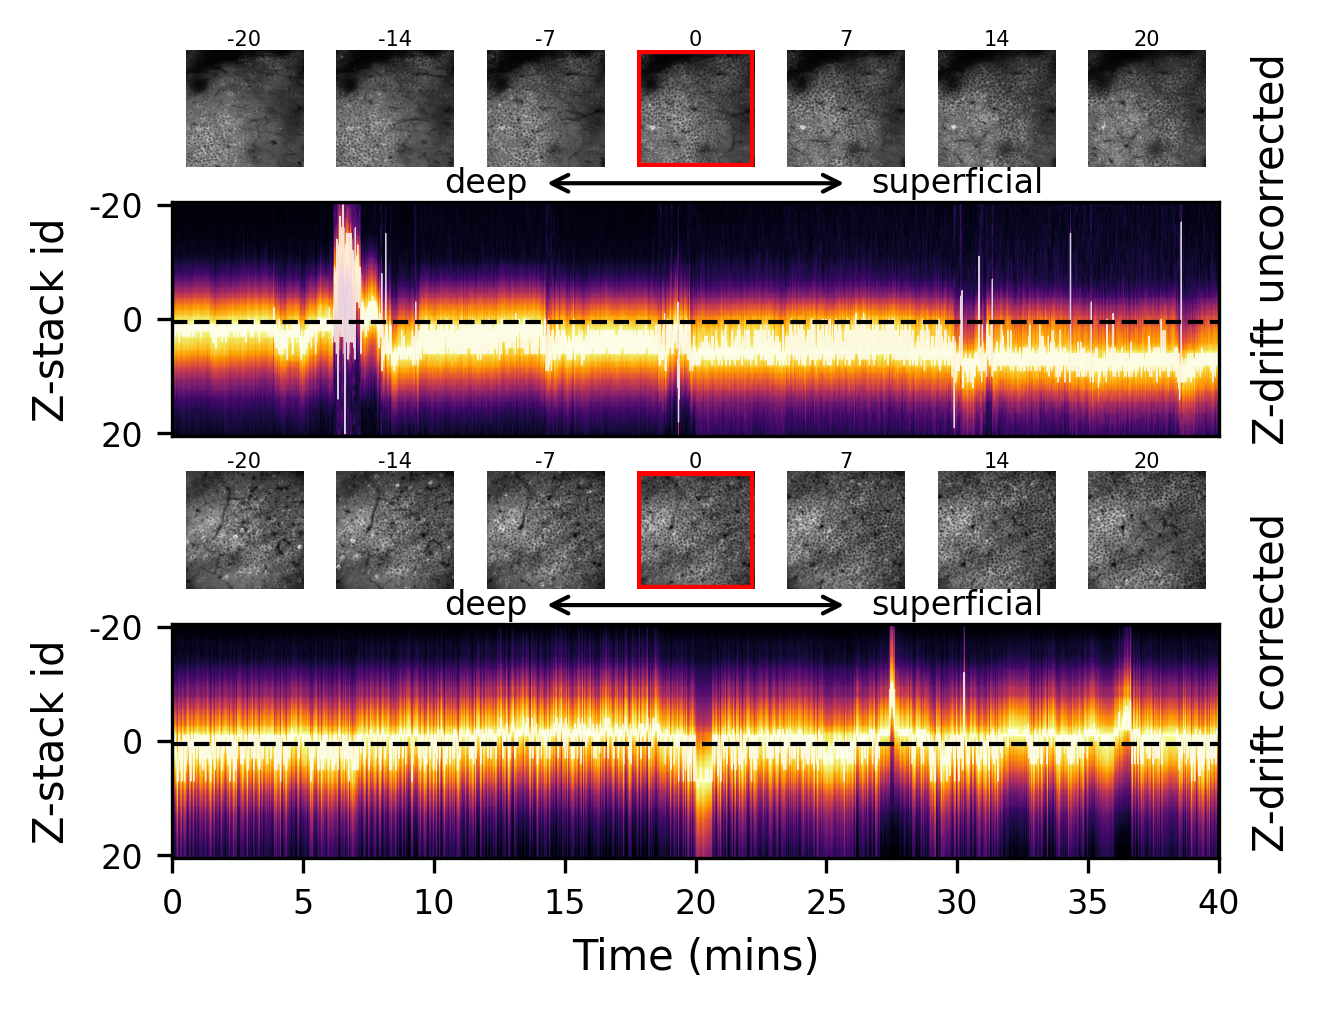

In [33]:
#plot
fig = plt.figure(figsize=(4.5, 3.5), dpi=300)

labelsize = 10
ticksize = 8

N = 7 #show N zstacks equally sampled from the meanstacks

gs = GridSpec(4, N, height_ratios=[0.5,1,0.5,1], wspace=0.05)
    
################z drift uncorrected#######################
datafolder = "/media/zilong/4TB Storage HDD/2PImaging/zstack/results"
meanstacks = tf.imread(os.path.join(datafolder,"zstacks.tif"))

#equally sample 10 elements from meanstacks
step = meanstacks.shape[0]//N
meanstacks_select = meanstacks[::step]

ops = np.load(datafolder+'/15122022_00002/suite2p/plane0/ops.npy', allow_pickle=True).item()
meanImg_uc = ops['meanImg']

#plot the meanstacks_select
titles = [-20, -14, -7, 0, 7, 14, 20]
for i in range(N):
    axi = fig.add_subplot(gs[0,i])
    #histogram matching
    meanstacks_select[i] = hist_match(meanstacks_select[i], meanImg_uc)
    axi.imshow(meanstacks_select[i], cmap='gray')
    axi.set_xticks([]); 
    axi.set_yticks([]); 
    axi.axis('off')
    axi.set_title(titles[i], fontsize=5, pad=-10)
    #when i == N//2 add red box to indicate the imaging plane
    if i == N//2:
        rect = plt.Rectangle((0, 0), meanstacks_select[i].shape[1], meanstacks_select[i].shape[0], fill=False, edgecolor='red', linewidth=2)
        axi.add_patch(rect)


###########################ax1###########################
ax1 = fig.add_subplot(gs[1, :]) 

#load the uncorrected zcorrlation matrix
ops = np.load('/media/zilong/4TB Storage HDD/2PImaging/zstack/results/15122022_00002/suite2p/plane0/ops.npy', allow_pickle=True).item()
corr02 = ops['zcorr']
ops = np.load('/media/zilong/4TB Storage HDD/2PImaging/zstack/results/15122022_00003/suite2p/plane0/ops.npy', allow_pickle=True).item()
corr03 = ops['zcorr']

#concate zcorr02 and zcorr03
corrMatrix_uncorrected = np.concatenate((corr02,corr03),axis=1)
binsize = 10
#bin the corrMatrix every 10 stesp along axis 1
# corrMatrix_uncorrected = np.mean(corrMatrix_uncorrected.reshape(corrMatrix_uncorrected.shape[0],-1,binsize),axis=2)
#sample evenry binsize frames along axis 1
corrMatrix_uncorrected = corrMatrix_uncorrected[:,::binsize]
#normalze corrMatrix_bin along axis 0 to 0-1
corrMatrix_uncorrected = (corrMatrix_uncorrected-np.min(corrMatrix_uncorrected,axis=0))/(np.max(corrMatrix_uncorrected,axis=0)-np.min(corrMatrix_uncorrected,axis=0))

ax1.imshow(corrMatrix_uncorrected, aspect='auto',cmap='inferno')

nplanes, nframes = corrMatrix_uncorrected.shape
driftcenter = nplanes//2
#get the index of maximum value at each cloumn in corrMatrix
maxIndex = np.argmax(corrMatrix_uncorrected, axis=0)
#get teh drift value by subtracting the driftcenter and taking the absolute value
drift =  np.abs(maxIndex - driftcenter)
#add plot at the maximum value in each column to the plot
ax1.plot(np.arange(0, nframes), maxIndex, color='white', linestyle='-', linewidth=0.3, alpha=0.8)

#add a line to separate the two blocks
ax1.axhline(y=nplanes/2, color='black', linestyle='--', linewidth=1)

#xticks off
ax1.set_xticks([])
#center ylabel
ax1.set_ylabel('Z-stack id', fontsize=labelsize)
#recenter the y label with zero representing the middle stack
ax1.set_yticks(np.arange(0, nplanes, 20))    
ax1.set_yticklabels(np.arange(0, nplanes, 20)-driftcenter)
#tick font
ax1.tick_params(axis='both', which='major', labelsize=ticksize)

#add bi-direction arrows on top of ax5 pointing to the left and right using annotate
ax1.annotate('', xy=(0.35, 1.08), xycoords='axes fraction', xytext=(0.65, 1.08), arrowprops=dict(arrowstyle="<->", color='black', linewidth=1.0))
#place text at two ends of the arrow using annotate
ax1.annotate('superficial', xy=(0.75, 1.08), xycoords='axes fraction', xytext=(0.75, 1.08), fontsize=ticksize, horizontalalignment='center', verticalalignment='center')
ax1.annotate('deep', xy=(0.30, 1.08), xycoords='axes fraction', xytext=(0.30, 1.08), fontsize=ticksize, horizontalalignment='center', verticalalignment='center')

#add text on the right side of the plot 
ax1.text(1.05, 0.8, 'Z-drift uncorrected', fontsize=labelsize, horizontalalignment='center', verticalalignment='center', transform=ax1.transAxes, rotation=90)

################z drift corrected#######################

datafolder = "/media/zilong/4TB Storage HDD/2PImaging/183_03082023"
processed_datafolder = os.path.join(datafolder, 'UnrotTiff/suite2p/plane0')
#load ops
ops =  np.load(os.path.join(processed_datafolder, 'ops.npy'), allow_pickle=True)
ops = ops.item()
meanImg_c = ops['meanImg']
#load meanstacks.npy from datafolder, DP_exp
meanstacks = np.load(os.path.join(datafolder, "DP_exp", "meanstacks.npy"))

#cut the middle 40 rows of the meanstacks
meanstacks_cut = meanstacks[int(meanstacks.shape[0]/2)-20:int(meanstacks.shape[0]/2)+21, :, :]
#save the meanstacks_cut to tiff file
tf.imsave(os.path.join(savefolder, 'meanstacks_cut.tif'), meanstacks_cut)

#equally sample elements from meanstacks
step = meanstacks_cut.shape[0]//N
meanstacks_select = meanstacks_cut[::step]

#plot the meanstacks_select
titles = [-20, -14, -7, 0, 7, 14, 20]
for i in range(N):
    axi = fig.add_subplot(gs[2,i])
    #histogram matching
    meanstacks_select[i] = hist_match(meanstacks_select[i], meanImg_c)
    axi.imshow(meanstacks_select[i], cmap='gray')
    axi.set_xticks([]); 
    axi.set_yticks([]); 
    axi.axis('off')
    axi.set_title(titles[i], fontsize=5, pad=-10)
    #when i == N//2 add red box to indicate the imaging plane
    if i == N//2:
        rect = plt.Rectangle((0, 0), meanstacks_select[i].shape[1], meanstacks_select[i].shape[0], fill=False, edgecolor='red', linewidth=2)
        axi.add_patch(rect)

###########################ax3###########################

nplanes, nframes = corrMatrix_correct.shape
driftcenter = nplanes//2

ax3 = fig.add_subplot(gs[3, :])

#normalze the corrMatrix to 0-1 along axis 0
corrMatrix_correct = (corrMatrix_correct - np.min(corrMatrix_correct, axis=0))/(np.max(corrMatrix_correct, axis=0) - np.min(corrMatrix_correct, axis=0))

ax3.imshow(corrMatrix_correct, aspect='auto',cmap='inferno')

#get the index of maximum value at each cloumn in corrMatrix
maxIndex = np.argmax(corrMatrix_correct, axis=0)
#get teh drift value by subtracting the driftcenter and taking the absolute value
drift =  np.abs(maxIndex - driftcenter)
#add plot at the maximum value in each column to the plot
ax3.plot(np.arange(0, nframes), maxIndex, color='white', linestyle='-', linewidth=0.3, alpha=0.8)

#add a line to separate the two blocks
ax3.axhline(y=nplanes/2, color='black', linestyle='--', linewidth=1)

#set xlim
ax3.set_xlim([0, nframes])
ax3.set_xlabel('Time (mins)', fontsize=labelsize)
# set x ticks 
xticks = np.arange(0, nframes+1, 900)
ax3.set_xticks(xticks)
Nticks = len(xticks)
ax3.set_xticklabels(np.arange(0, Nticks)*5)
#set xticks off
#ax1.set_xticks([])
#center ylabel
ax3.set_ylabel('Z-stack id', fontsize=labelsize)
#recenter the y label with zero representing the middle stack
ax3.set_yticks(np.arange(0, nplanes, 20))    
ax3.set_yticklabels(np.arange(0, nplanes, 20)-driftcenter)
#tick font
ax3.tick_params(axis='both', which='major', labelsize=ticksize)

#add bi-direction arrows on top of ax5 pointing to the left and right using annotate
ax3.annotate('', xy=(0.35, 1.08), xycoords='axes fraction', xytext=(0.65, 1.08), arrowprops=dict(arrowstyle="<->", color='black', linewidth=1.0))
#place text at two ends of the arrow using annotate
ax3.annotate('superficial', xy=(0.75, 1.08), xycoords='axes fraction', xytext=(0.75, 1.08), fontsize=ticksize, horizontalalignment='center', verticalalignment='center')
ax3.annotate('deep', xy=(0.30, 1.08), xycoords='axes fraction', xytext=(0.30, 1.08), fontsize=ticksize, horizontalalignment='center', verticalalignment='center')

#add text on the right side of the plot 
ax3.text(1.05, 0.75, 'Z-drift corrected', fontsize=labelsize, horizontalalignment='center', verticalalignment='center', transform=ax3.transAxes, rotation=90)

plt.tight_layout()

plt.savefig("../Figures/Figure2_driftcorrection.pdf", dpi=300)

### 3, comparing first 500 frames and last 500 frames in 40 ins recording

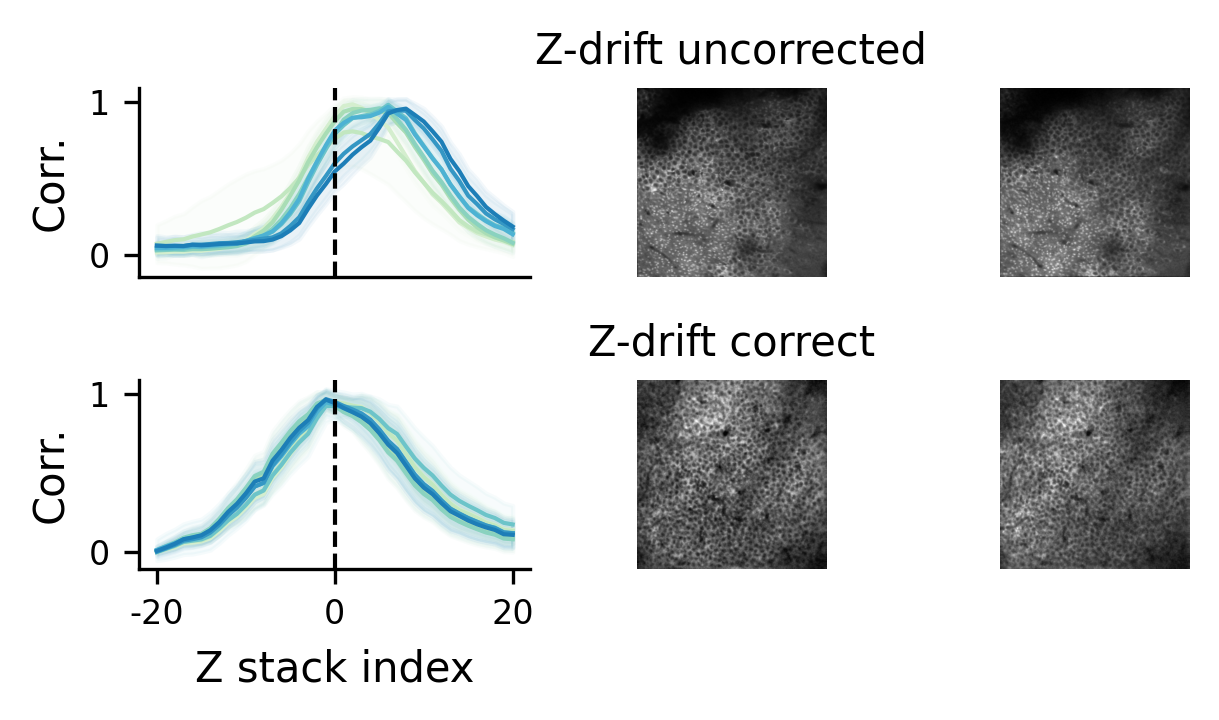

In [34]:

#split corrMatrix_uncorrected every 900 steps along axis 1, store into a 3D array
corrMatrix_uncorrected_split = np.array(np.split(corrMatrix_uncorrected, nframes//900, axis=1))
#calculate the mean and std along axis 2
corrMatrix_uncorrected_mean = np.mean(corrMatrix_uncorrected_split, axis=2)
corrMatrix_uncorrected_std = np.std(corrMatrix_uncorrected_split, axis=2)

#imshow the averaged image
fig = plt.figure(figsize=(4.5,2.5), dpi=300)
gs = GridSpec(2, 3, width_ratios=[1.2,1,1])

ax1 = fig.add_subplot(gs[0,0])

nsplits, nplanes = corrMatrix_uncorrected_mean.shape
#colors in GnBu from light to dark, equally spaced
colors = plt.cm.GnBu(np.linspace(0.2, 0.8, nsplits))
for i in range(nsplits):
    mean_ = corrMatrix_uncorrected_mean[i]
    std_ = corrMatrix_uncorrected_std[i]
    ax1.plot(np.arange(0, nplanes), mean_, color=colors[i], linewidth=1)
    ax1.fill_between(np.arange(0, nplanes), mean_-std_, mean_+std_, color=colors[i], alpha=0.05)
#ax1.set_xlabel('Z-stack id', fontsize=labelsize)
ax1.set_ylabel('Correlation', fontsize=labelsize)

#add vertical line to indicate the center plane at nplanes//2
ax1.axvline(x=nplanes//2, color='k', linestyle='--', linewidth=1)
#chnage the xticks from [0, nplanes-1] to [-nplanes//2, nplanes//2]
# ax1.set_xticks([0,20,40])
# ax1.set_xticklabels([-20, 0,20])
ax1.set_xticks([])
#yticks as scientific notation
ax1.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
#ax1.set_xlabel('Z stack index', fontsize=labelsize)
ax1.set_ylabel('Corr.', fontsize=labelsize)
#tick font size as ticksize
ax1.tick_params(axis='both', which='major', labelsize=ticksize)
#remove the top and right spines
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
#title
#ax1.set_title('Uncorrected', fontsize=labelsize)

# #add colorbar to indicate the time display horizontal at the top of ax1
# cbar = fig.colorbar(plt.cm.ScalarMappable(cmap='GnBu'), ax=ax1, fraction=0.1, pad=0, shrink=0.8, orientation='horizontal')
# cbar.set_ticks([0,1])
# cbar.set_ticklabels(['0', '40'])
# #cbae tick font size as ticksize
# cbar.ax.tick_params(labelsize=ticksize)
# cbar.outline.set_visible(False)
# #cbar tick bar off
# cbar.ax.tick_params(size=0)

ax1_1 = fig.add_subplot(gs[0,1])
first500 = np.load('/media/zilong/4TB Storage HDD/2PImaging/zstack/results/first500.npy')

#plot the mean of first 500 frames
first500 = hist_match(first500, meanImg_uc)
ax1_1.imshow(first500, cmap='gray')
ax1_1.set_xticks([]); ax1_1.set_yticks([])
ax1_1.axis('off')
ax1_1.set_xlabel('start', fontsize=labelsize)
ax1_1.set_title('Z-drift uncorrected', fontsize=labelsize)

ax1_2 = fig.add_subplot(gs[0,2])
last500 = np.load('/media/zilong/4TB Storage HDD/2PImaging/zstack/results/last500.npy')

#plot the mean of first 500 frames
last500 = hist_match(last500, meanImg_uc)
ax1_2.imshow(last500, cmap='gray')
ax1_2.set_xticks([]); ax1_2.set_yticks([])
ax1_2.axis('off')
ax1_2.set_xlabel('end', fontsize=labelsize)

#do the same for the corrected corrMatrix
corrMatrix_correct_split = np.array(np.split(corrMatrix_correct, nframes//900, axis=1))
corrMatrix_correct_mean = np.mean(corrMatrix_correct_split, axis=2)
corrMatrix_correct_std = np.std(corrMatrix_correct_split, axis=2)


ax2 = fig.add_subplot(gs[1,0])

nsplits, nplanes = corrMatrix_correct_mean.shape
#colors in GnBu from light to dark, equally spaced
colors = plt.cm.GnBu(np.linspace(0.2, 0.8, nsplits))
for i in range(nsplits):
    mean_ = corrMatrix_correct_mean[i]
    std_ = corrMatrix_correct_std[i]
    ax2.plot(np.arange(0, nplanes), mean_, color=colors[i], linewidth=1)
    ax2.fill_between(np.arange(0, nplanes), mean_-std_, mean_+std_, color=colors[i], alpha=0.05)
ax2.set_xlabel('Z-stack id', fontsize=labelsize)
ax2.set_ylabel('Correlation', fontsize=labelsize)

#add vertical line to indicate the center plane at nplanes//2
ax2.axvline(x=nplanes//2, color='k', linestyle='--', linewidth=1)

#chnage the xticks from [0, nplanes-1] to [-nplanes//2, nplanes//2]
ax2.set_xticks([0,20,40])
ax2.set_xticklabels([-20, 0,20])
#yticks as scientific notation
ax2.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
ax2.set_xlabel('Z stack index', fontsize=labelsize)
ax2.set_ylabel('Corr.', fontsize=labelsize)
#tick font size as ticksize
ax2.tick_params(axis='both', which='major', labelsize=ticksize)
#remove the top and right spines
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
#title

# #add colorbar to indicate the time
# cbar = fig.colorbar(plt.cm.ScalarMappable(cmap='GnBu'), ax=ax2, fraction=0.1, pad=0, shrink=0.8, orientation='horizontal')
# cbar.set_ticks([0,1])
# cbar.set_ticklabels(['0', '40'])
# #cbae tick font size as ticksize
# cbar.ax.tick_params(labelsize=ticksize)
# #cbar box off
# cbar.outline.set_visible(False)
# cbar.ax.tick_params(size=0)

ax2_1 = fig.add_subplot(gs[1,1])

datafolder = "/media/zilong/4TB Storage HDD/2PImaging/183_03082023"
#show meanImage from first tiff and last tiff and all
#first tiff
RegTif_folder = os.path.join(datafolder, 'UnrotTiff/suite2p/plane0/reg_tif')

filename_tif0 = 'file000_chan0.tif'
# Load the registered tiff image
images = []
with tf.TiffFile(os.path.join(RegTif_folder, filename_tif0)) as tif:
    for page in tif.pages:
        image = page.asarray()
        images.append(image)
#get the mean image
meanImage_tif0 = np.mean(images, axis=0)
#convert to int16
meanImage_tif0 = meanImage_tif0.astype(np.int16)   
meanImage_tif0 = hist_match(meanImage_tif0, meanImg_c)

#plot the mean of first 500 frames
ax2_1.imshow(meanImage_tif0, cmap='gray')
ax2_1.set_xticks([]); ax2_1.set_yticks([])
ax2_1.axis('off')
ax2_1.set_xlabel('start', fontsize=labelsize)
ax2_1.set_title('Z-drift correct', fontsize=labelsize)

ax2_2 = fig.add_subplot(gs[1,2])

filename_tifN = 'file72000_chan0.tif'     
# Load the registered tiff image
images = []
with tf.TiffFile(os.path.join(RegTif_folder, filename_tifN)) as tif:
    for page in tif.pages:
        image = page.asarray()
        images.append(image)
#get the mean image
meanImage_tifN = np.mean(images, axis=0)
#convert to int16
meanImage_tifN = meanImage_tifN.astype(np.int16)
meanImage_tifN = hist_match(meanImage_tifN, meanImg_c)
#plot the mean of first 500 frames
ax2_2.imshow(meanImage_tifN, cmap='gray')
ax2_2.set_xticks([]); ax2_2.set_yticks([])
ax2_2.axis('off')
ax2_2.set_xlabel('end', fontsize=labelsize)

plt.tight_layout()

#save
plt.savefig("../Figures/Figure2_driftcorrection_first_and_last500.pdf", dpi=300)


### 4, plot behavioral correlation with z drift

#### 4.1 get the correlation matrix for the first 4000 frames

In [36]:
binsize = 1
savefolder = os.path.join(datafolder, 'UnrotTiff/2D2P')
corrMatName = 'corrMatrix_binsize_' + str(binsize) + '.pkl'
#check if corrMatrix.pkl exists under savefolder
if os.path.isfile(os.path.join(savefolder, corrMatName)):
    with open(os.path.join(savefolder, corrMatName), 'rb') as f:
        all_corrMatrix = pickle.load(f)
else:
    #read all tif under the folder RegTif_folder 
    filenames = os.listdir(RegTif_folder)
    #sort the filenames by number
    filenames.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))
    #keep the first 4000 frames, which are the first 8 files
    filenames = filenames[:8]
    # Load the registered tiff image
    all_corrMatrix = {}
    for filename in filenames:
        print('processing: ' + filename)
        regFrames = []
        with tf.TiffFile(os.path.join(RegTif_folder, filename)) as tif:
            for page in tif.pages:
                image = page.asarray()
                #transpose the image because the image is rotated after suite2p processing
                regFrames.append(image.T)
        regFrames = np.array(regFrames)
        
        #bin every binsize frames and take the mean
        bin_regFrames = regFrames.reshape(-1, binsize, regFrames.shape[1], regFrames.shape[2]).mean(axis=1)
                
        #perform phase correlation
        _, _, corrMatrix = compute_zpos_sp(meanstacks, bin_regFrames, ops)
        
        #append the corrMatrix to all_corrMatrix
        all_corrMatrix[filename] = corrMatrix 
    
    #save the all_corrMatrix to pickle file
    with open(os.path.join(savefolder, corrMatName), 'wb') as f:
        pickle.dump(all_corrMatrix, f)

#for all elements in all_corrMatrix, concatenate them by the first dimension
corrMatrix = np.concatenate(list(all_corrMatrix.values()), axis=1)
nplanes, nframes = corrMatrix.shape

#### 4.2 load trajectory

In [37]:

filenamelist = ["00004", "00005", "00006", "00007", "00008", "00009", "00010", "00012", "00014", "00016", "00017", "00018"]
datafolder = "/media/zilong/4TB Storage HDD/2PImaging/183_03082023"
#if trajectory is already saved in pickle file, load it
if os.path.exists(os.path.join(datafolder,'UnrotTiff', '2D2P','trajectory.pickle')):
    with open(os.path.join(datafolder,'UnrotTiff', '2D2P','trajectory.pickle'), 'rb') as f:
        trajectory = pickle.load(f)
    allX = trajectory[0]
    allZ = trajectory[1]
    allTime = trajectory[2]
    allTheta = trajectory[3]
else:
    allX, allZ, allTime, allTheta, fig = plot_trajectory(datafolder, filenamelist)
    
#change allX and allZ from dictionary to np.array
Traj_x = np.concatenate(list(allX.values()))
Traj_z = np.concatenate(list(allZ.values()))
Theta = np.concatenate(list(allTheta.values()))
#change degree to radian]
Theta = Theta/180*np.pi

#normalize x and z to [0,1]
Traj_x = (Traj_x-np.min(Traj_x))/(np.max(Traj_x)-np.min(Traj_x))
Traj_z = (Traj_z-np.min(Traj_z))/(np.max(Traj_z)-np.min(Traj_z))

#concatenate the time stamps, a
# add 0.033 + the last element to make sure the time stamps at each boundary are not the same using for loop
for i in range(len(allTime)):
    #chnage allTime[i] to np.array
    allTime[i] = np.array(allTime[i])
    if i == 0:
        timestamps = allTime[i]
    else:
        timestamps = np.concatenate((timestamps, allTime[i]+timestamps[-1]+0.033))

#get the linear speed
linearspeed = getLinearSpeed(Traj_x, Traj_z, timestamps, boxcar_size=0)

#cut the speed to the same length
linearspeed = linearspeed[:nframes*binsize]
#every binsize data points, take the mean
linearspeed = linearspeed.reshape(-1, binsize).mean(axis=1)
linearspeed = linearspeed*60
            
#get the angular speed
angularspeed = getAngularSpeed(Theta, timestamps)  
#cut the angular_speed to the same length 
angularspeed = angularspeed[:nframes*binsize]
#every binsize data points, take the mean
angularspeed = angularspeed.reshape(-1, binsize).mean(axis=1)     

/tmp/ipykernel_374447/275397957.py:149: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


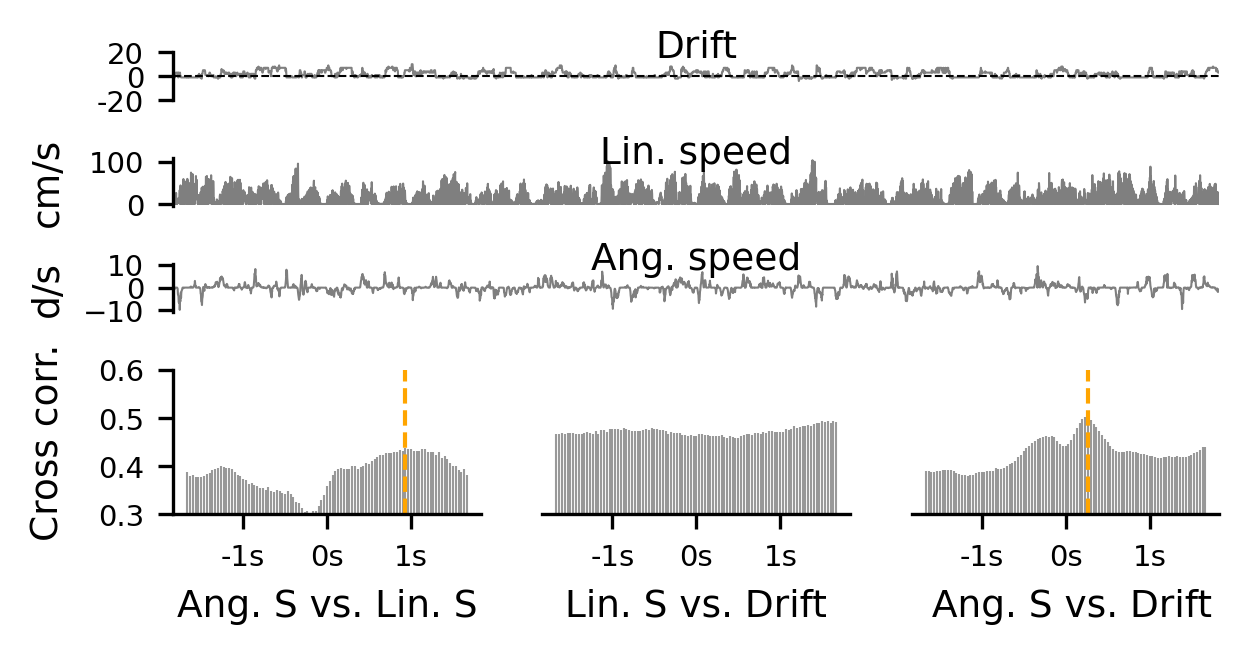

In [38]:
#two subplots using gridspec, one for correlation matrix and one for speed
fig = plt.figure(figsize=(4.5, 2),dpi=300)

labelsize = 9
ticksize = 7

gs = GridSpec(4, 3, height_ratios=[1, 1, 1, 3], width_ratios=[1, 1, 1], hspace=0.8)

###########################ax00###########################
ax0 = fig.add_subplot(gs[0, :])

driftcenter = int(nplanes/2)
#get the index of maximum value at each cloumn in corrMatrix
maxIndex = np.argmax(corrMatrix, axis=0)
#get teh drift value by subtracting the driftcenter and taking the absolute value
drift =  np.abs(maxIndex - driftcenter)
#add plot at the maximum value in each column to the plot
ax0.plot(np.arange(0, nframes), maxIndex, color='grey', linestyle='-', linewidth=0.5)

#add a line to separate the two blocks
ax0.axhline(y=nplanes/2, color='black', linestyle='--', linewidth=0.5)

#set xlim
ax0.set_xlim([0, nframes])
# #set x ticks every 1000 frames
# xticks = np.arange(0, nframes, 1000)
# ax1.set_xticks(xticks)
# ax1.set_xticklabels(xticks*binsize)
#set xticks off
ax0.set_xticks([])
#ax0.set_title('Drift', fontsize=labelsize)
#add title as text
ax0.text(0.5, 1.1, 'Drift', fontsize=labelsize, horizontalalignment='center', verticalalignment='center', transform=ax0.transAxes)
#recenter the y label with zero representing the middle stack
ax0.set_yticks([20,40,60])  
ax0.set_yticklabels([-20,0,20])
ax0.spines['bottom'].set_visible(False)

############################ax11###########################
ax1 = fig.add_subplot(gs[1, :])
#choose colormap when plot, equally sampled from tab20c accodring to the number of sessions
colors = plt.cm.tab20c(np.linspace(0, 1, len(allX)))

ax1.plot(linearspeed, linewidth=0.5, color='k', alpha=0.5)

#set xticks off
ax1.set_xticks([])
#set xlim
ax1.set_xlim([0, nframes])
# #xlabel and ylabel and rotation for 90 degree
ax1.set_ylabel('cm/s', fontsize=labelsize)
#add title as text
ax1.text(0.5, 1.1, 'Lin. speed', fontsize=labelsize, horizontalalignment='center', verticalalignment='center', transform=ax1.transAxes)

ax1.spines['bottom'].set_visible(False)

############################ax21###########################
ax2 = fig.add_subplot(gs[2, :])
ax2.plot(angularspeed, linewidth=0.5, color='k', alpha=0.5)

#set x ticks every 1000 frames
#xticks = np.arange(0, nframes, 1000)
#ax2.set_xticks(xticks)
#ax2.set_xticklabels(xticks*binsize)
#set xlim
ax2.set_xlim([0, nframes])
#xlabel and ylabel  
#ax2.set_xlabel('Frame Index', fontsize=labelsize)
#xticks off
ax2.set_xticks([])
#center align the y label
ax2.set_ylabel('d/s', fontsize=labelsize)
#add title as text
ax2.text(0.5, 1.1, 'Ang. speed', fontsize=labelsize, horizontalalignment='center', verticalalignment='center', transform=ax2.transAxes)
ax2.spines['bottom'].set_visible(False)

############################ax30###########################
ax31 = fig.add_subplot(gs[3, 0])
lag = 50
#third, perform cross correlation with lag = 10 frames, and plot the result, between linearspeed and np.abs(angularspeed)
ax31.xcorr(linearspeed, np.abs(angularspeed), usevlines=True, maxlags=lag, normed=True, lw=0.5, color='grey', alpha=0.8)

#do coross correlation between drift and angular speed using numpy
cc = np.correlate(linearspeed, np.abs(angularspeed), mode='full')
#find the shift of maximum correlation
shift = np.argmax(cc)-len(drift)+1
#mark the shift with a vertical orange line
ax31.axvline(x=shift, color='orange', linestyle='--', linewidth=1)

ax31.set_xlabel('Ang. S vs. Lin. S', fontsize=labelsize)
ax31.set_ylabel('Cross corr.', fontsize=labelsize)
#set y lim from 0 to 0.5
ax31.set_ylim([0.3, 0.6])
#set xtick labels
ax31.set_xticks([-30, 0, 30])
ax31.set_xticklabels(['-1s', '0s', '1s'])
#set tick size
ax31.tick_params(labelsize=ticksize)


############################ax31###########################
ax32 = fig.add_subplot(gs[3, 1])
#second, perform cross correlation between linearspeed, drift, and plot the result with lag = 10 frames, and plot the result
ax32.xcorr(drift, linearspeed, usevlines=True, maxlags=lag, normed=True, lw=0.5, color='grey', alpha=0.8)
ax32.set_xlabel('Lin. S vs. Drift', fontsize=labelsize)
#set y lim from 0 to 0.5
ax32.set_ylim([0.3, 0.6])
ax32.set_yticks([])
#set xtick labels
ax32.set_xticks([-30, 0, 30])
ax32.set_xticklabels(['-1s', '0s', '1s'])
#set tick size
ax32.tick_params(labelsize=ticksize)
ax32.spines['left'].set_visible(False) 

############################ax32###########################
ax33 = fig.add_subplot(gs[3, 2])
#second, perform cross correlation with lag = 10 frames, and plot the result
ax33.xcorr(drift, np.abs(angularspeed), usevlines=True, maxlags=lag, normed=True, lw=0.5, color='grey', alpha=0.8)

#do coross correlation between drift and angular speed using numpy
cc = np.correlate(drift, np.abs(angularspeed), mode='full')
#find the shift of maximum correlation
shift = np.argmax(cc)-len(drift)+1
#mark the shift with a vertical orange line
ax33.axvline(x=shift, color='orange', linestyle='--', linewidth=1)

ax33.set_xlabel(' Ang. S vs. Drift', fontsize=labelsize)
#set y lim from 0 to 0.5
ax33.set_ylim([0.3, 0.6])
ax33.set_yticks([])
#set xtick labels
ax33.set_xticks([-30, 0, 30])
ax33.set_xticklabels(['-1s', '0s', '1s'])
#font size
ax33.tick_params(labelsize=ticksize)
ax33.spines['left'].set_visible(False) 

#remove top and right spines for all axes using for loop
for ax in [ax0, ax1, ax2, ax31, ax32, ax33]:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(labelsize=ticksize)

# align ylabels
fig.align_ylabels([ax1, ax2, ax31])

#tight_layout
plt.tight_layout()

plt.savefig("../Figures/Figure2_behavioralcorelation_with_drift.pdf", dpi=300)

In [57]:
binsize

10